In [11]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
import json
from numpy import linalg as LA
import tensorflow as tf
from sklearn.decomposition import PCA

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from analysis import clustering, standard_analysis, variance
import numpy.random as npr
from tools_lnd import make_h_all, PC_axes, get_T_inds, make_dendro
from collections import OrderedDict

In [12]:
def make_h_all(m,mode = 'test',rules = []):
    
    model = FixedPoint_Model(m, sigma_rec=0)

    with tf.Session() as sess:
        model.restore()
        model._sigma=0

        h_all_byrule = OrderedDict()
        h_all_byepoch = OrderedDict()

        hp = model.hp
        n_hidden = hp['n_rnn']

        if len(rules)==0:
            rules = hp['rules']

        for rule in rules:
            trial = generate_trials(rule, hp, mode = mode, noise_on=False, batch_size = 100)
            feed_dict = tools.gen_feed_dict(model, trial, hp)
            h = sess.run(model.h, feed_dict=feed_dict)
            for e_name, e_time in trial.epochs.items():
                if 'fix' not in e_name:  # Ignore fixation period
                    h_all_byepoch[(rule, e_name)] = h[e_time[0]:e_time[1],:,:]
                    h_all_byrule[rule] = h

    return h_all_byepoch, h_all_byrule

In [13]:
n_rnn = 128
l2w = -6
l2h = -6
l1w = 0
l1h = 0
seed = 1
lr = -6
sigma_rec = 1/20
sigma_x = 2/20
pop_rule = 5
ruleset = 'all'
w_rec_coeff  = 8/10

seed_set = [str(0),str(1),str(2)]#[str(0),str(1)]

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

rule_trains_str = '_'.join(rule_trains)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/sherlock/multitask-nets/stepnet/data/sca/LeakyRNN/softplus/diag/6_tasks/128_n_rnn/lr8.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/sherlock/multitask-nets/stepnet/data/sca/LeakyRNN/softplus/diag/6_tasks/128_n_rnn/lr8.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti/0/model.ckpt


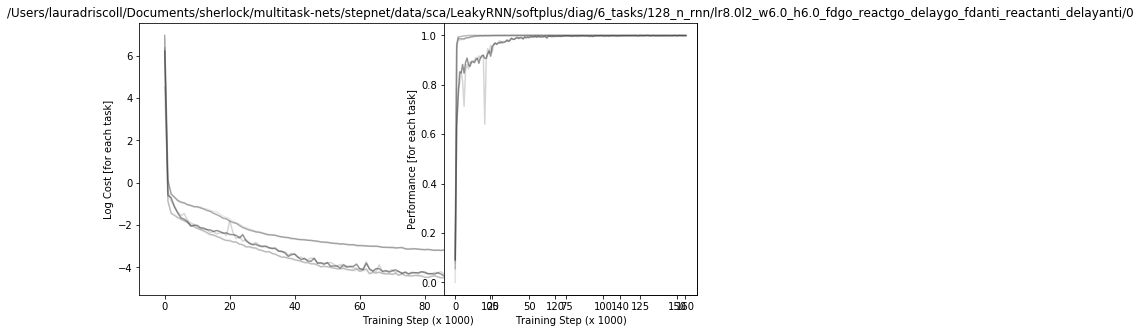

In [26]:
m = '/Users/lauradriscoll/Documents/sherlock/multitask-nets/stepnet/data/sca/LeakyRNN/softplus/diag/6_tasks/128_n_rnn/lr8.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti/0'
# m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/1_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delayanti/0/'
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp

fig = plt.figure(figsize=(10, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(m, 'log.json')
task_list = hparams['rule_trains']

with open(fname, 'r') as f:
    log_all = json.load(f)
for r in range(len(task_list)):
    c = cmap((r+1)/(len(task_list)+1))
    
    ax1 = fig.add_subplot(1,1,1)
    x = np.log(log_all['cost_'+task_list[r]])
    plt.plot(x,'-',c = c,alpha = .5)

    ax2 = fig.add_subplot(1,2,2)
    x = log_all['perf_'+task_list[r]]
    plt.plot(x,'-',c = c,alpha = .5)

ax1.set_xlabel('Training Step (x 1000)')
ax1.set_ylabel('Log Cost [for each task]')    
ax2.set_xlabel('Training Step (x 1000)')
ax2.set_ylabel('Performance [for each task]')
plt.title(m)
plt.show()    

In [27]:
h_all_byepoch, h_all_byrule =  make_h_all(m,mode = 'test',rules = [])
h_all = {'by_rule':h_all_byrule,'by_epoch':h_all_byepoch}
np.savez(os.path.join(m,'h_all.npz'),**h_all)

Overwrite sigma_rec with 0.000
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/sherlock/multitask-nets/stepnet/data/sca/LeakyRNN/softplus/diag/6_tasks/128_n_rnn/lr8.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/sherlock/multitask-nets/stepnet/data/sca/LeakyRNN/softplus/diag/6_tasks/128_n_rnn/lr8.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti/0/model.ckpt


In [28]:
#MAKE COR MATS
# set of networks to compare
import matplotlib.patches as patches
rnn_type_set = ['LeakyGRU','LeakyRNN']
activation_set = ['tanh','retanh','softplus']
w_init_set = ['diag','randgauss']
data_folder_set = ['final1', ]# 

for rnn_type_i in range(len(rnn_type_set)):
    for activation_i in range(len(activation_set)):
        for w_init_i in range(len(w_init_set)):
            for data_folder in data_folder_set:
            
                rnn_type = rnn_type_set[rnn_type_i]
                activation = activation_set[activation_i]
                w_init = w_init_set[w_init_i]

                for seed in seed_set:
                        
                    if (rnn_type == 'LeakyRNN') & (activation == 'tanh') & (data_folder == 'final1'):
                        w_rec_coeff  = 1
                        lr = -8
                    else:
                        w_rec_coeff  = 8/10
                        lr = -6
                        
                    net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)

                    net_name2 = '_sig_rec'+str(sigma_rec)+'_sig_x'+str(sigma_x)+'_w_rec_coeff'+"{:.1f}".format(w_rec_coeff)+'_'+rule_trains_str

                    m = os.path.join(p,'data','rnn','multitask',net,data_folder,ruleset,
                                            rnn_type,activation,w_init,str(len(rule_trains))+'_tasks',
                                            str(n_rnn)+'_n_rnn',net_name+net_name2,str(seed))
                    
                    h_all_byepoch, h_all_byrule =  make_h_all(m,mode = 'test',rules = [])
                    h_all = {'by_rule':h_all_byrule,'by_epoch':h_all_byepoch}
                    np.savez(os.path.join(m,'h_all.npz'),**h_all)
                    

Overwrite sigma_rec with 0.000
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyGRU/tanh/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyGRU/tanh/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


KeyboardInterrupt: 